In [1]:
import pickle
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import the training, validation, and testing data
training_file = '../data/train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = np.shape(X_train)[0]

# TODO: Number of validation examples
n_validation = np.shape(X_valid)[0]

# TODO: Number of testing examples.
n_test = np.shape(X_test)[0]

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# TODO: How many unique classes/labels there are in the dataset.
label_num=pd.read_csv('../CarND-Traffic-Sign-Classifier-Project/signnames.csv')
n_classes = np.shape(label_num)[0]

print("Number of training examples =", n_train)
print("Number of validing examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validing examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
#Preprocess all the images for training, validation, and testing data
def preprocess_image(img):
    num_img, height, width, channel=np.shape(img)
    img=img.reshape(img.shape[0], img.shape[1]*img.shape[2]*img.shape[3])
    #normalize the images, the range of the pixel value is [0, 1]
    img_norm=img/255
    #Substract the mean value of each images
    img_mean=np.mean(img_norm, axis=1)
    img_mean=img_mean[:, np.newaxis]
    img_mean_repeat=np.repeat(img_mean, img_norm.shape[1], axis=1)
    image=img_norm-img_mean_repeat
    image=image.reshape((num_img, height, width, channel))
    #Convert the Color images into grayscale images
    image_gray=np.sum(image/3, axis=3, keepdims=True)
    return image_gray

#Shuffle the training data set
#X_train, y_train = shuffle(X_train, y_train)

#for training data set do the preprocess before the data augmentation
#X_train=preprocess_image(X_train)
X_valid=preprocess_image(X_valid)
X_test=preprocess_image(X_test)

In [ ]:
###  Whitening, however, it takes too long
#cov = np.cov(X_train, rowvar=True)
#U,S,V = np.linalg.svd(cov)
#epsilon = 0.1
#X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_train)
#X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())

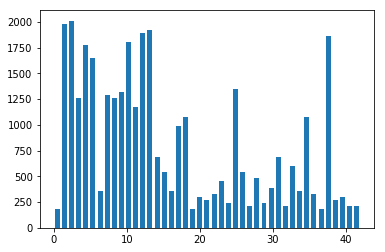

In [5]:
#show the histogram for the trainging data set
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

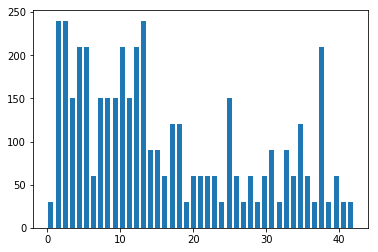

In [6]:
#show the histogram for the validation data set
hist, bins = np.histogram(y_valid, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

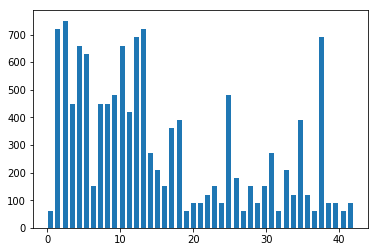

In [7]:
#show the histogram for the testing data set
hist, bins = np.histogram(y_test, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [ ]:
# changing the image brightness
def brightness(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    br = 10.3+np.random.uniform()
    if br > 1.0:
        br = 1.0
    img[:,:,2] = img[:,:,2]*br
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    return img

#rotating the images, angle range is [-10, 10] degree
def rotation(img):
    angle =np.random.randint(low=-10, high=10, size=1)
    image_center = tuple(np.array(img.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    dst = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    dst = dst[:,:,np.newaxis]
    return dst

# Adding gaussin blur
def gaussin_noise(img):
    col=np.shape(img)[0]
    row=np.shape(img)[1]
    gaussian = np.random.random((row, col, 1)).astype(np.float32)
    dst = cv2.addWeighted(img, 0.75, 0.25 * gaussian, 0.25, 0, dtype=0)
    dst = dst[:,:,np.newaxis]
    return dst

# Shifting the image location to the left, keep the image size the same
def translation_left(img):
    cols=np.shape(img)[0]
    rows=np.shape(img)[1]
    x, y =np.random.randint(low=1, high=8, size=2)
    M = np.float32([[1,0,x],[0,1,y]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    dst = dst[:,:,np.newaxis]
    return dst

#shifting the images location to the right, keep the image size the same
def translation_right(img):
    cols=np.shape(img)[0]
    rows=np.shape(img)[1]
    x, y =np.random.randint(low=-8, high=-1, size=2)
    M = np.float32([[1,0,x],[0,1,y]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    dst = dst[:,:,np.newaxis]
    return dst

In [ ]:
#data augmentation, for the trainging data size for each categories is larger than 800
input_indices = []
output_indices = []

for class_n in range(n_classes):
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train.shape[0])
            new_img = X_train[class_indices[0][i % n_samples]]
            # random choosing the augmentation category
            dice=np.random.randint(1,4, size=1)
            if dice==1:
                new_img= translation_left(new_img)
            elif dice==2:
                new_img=translation_right(new_img)
            else:
                new_img=rotation(new_img)
            #combine the original data with the augmentation data
            X_train= np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)

In [ ]:
#save the new training data and label in pickle file

#training_aug_file = "../data/X_train_aug.p"
#pickle.dump(X_train, open(training_aug_file, "wb" ))

#training_y_aug_file = "../data/y_train_aug.p"
#pickle.dump(y_train, open(training_y_aug_file, "wb" ))

In [8]:
# Read the trainign data set
training_aug_file = "../data/X_train_aug.p"
with open(training_aug_file, mode='rb') as f:
    X_train = pickle.load(f)

In [9]:
#Read the training label
training_y_aug_file = "../data/y_train_aug.p"
with open(training_y_aug_file, mode='rb') as f:
    y_train = pickle.load(f)

In [10]:
#shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

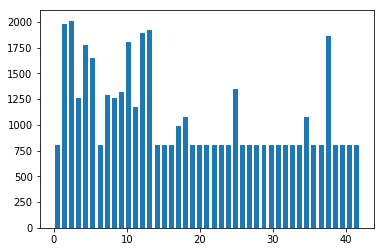

In [11]:
#show the histogram for the new training data
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [ ]:
# randomly show five augmentation data comparing with the original images
choices = list(range(len(input_indices)))
picks = []
for i in range(5):
    rnd_index = np.random.randint(low=0,high=len(choices))
    picks.append(choices.pop(rnd_index))
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    image = X_train[input_indices[picks[i]]].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap = 'gray')
    axs[i].set_title(y_train[input_indices[picks[i]]])
for i in range(5):
    image = X_train[output_indices[picks[i]]].squeeze()
    axs[i+5].axis('off')
    axs[i+5].imshow(image, cmap = 'gray')
    axs[i+5].set_title(y_train[output_indices[picks[i]]])

In [12]:
def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x64.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 64), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(64))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 32x32x64. Output = 16x16x64.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv1 = tf.layers.batch_normalization(conv1)

    # SOLUTION: Layer 2: Convolutional. Output = 16x16x128.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(128))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 16x16x128. Output = 8x8x128.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv2 = tf.layers.batch_normalization(conv2)
    
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 256), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(256))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    
    # SOLUTION: Activation.
    conv3 = tf.nn.relu(conv3)

    # SOLUTION: Pooling. Input = 8x8x256. Output = 4x4x256.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv3 = tf.layers.batch_normalization(conv3)
    
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 256, 512), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(512))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b
    
    # SOLUTION: Activation.
    conv4 = tf.nn.relu(conv4)

    # SOLUTION: Pooling. Input = 4x4x512. Output = 2x2x512.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv4 = tf.layers.batch_normalization(conv4)

    fc0 = flatten(conv4)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 2048. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1  = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc1 = tf.layers.batch_normalization(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    fc2 = tf.layers.batch_normalization(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [13]:
init_rate = 0.001
EPOCHS = 50
BATCH_SIZE =32
training_acc_history =[]
validation_acc_history =[]

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
step = tf.Variable(0, trainable=False)
rate = tf.train.exponential_decay(init_rate, step, 1, 0.9999)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation, global_step=step)
#training_operation = optimizer.minimize(loss_operation)

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #num_examples = len(X_train)
    num_examples=np.shape(X_train)[0]
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
        
        train_accuracy = evaluate(X_train, y_train)
        training_acc_history.append(train_accuracy)
        
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_acc_history.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './train_lenet.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.904

EPOCH 2 ...
Validation Accuracy = 0.959

EPOCH 3 ...
Validation Accuracy = 0.960

EPOCH 4 ...
Validation Accuracy = 0.970

EPOCH 5 ...
Validation Accuracy = 0.981

EPOCH 6 ...
Validation Accuracy = 0.974

EPOCH 7 ...
Validation Accuracy = 0.978

EPOCH 8 ...
Validation Accuracy = 0.975

EPOCH 9 ...
Validation Accuracy = 0.971

EPOCH 10 ...
Validation Accuracy = 0.980

EPOCH 11 ...
Validation Accuracy = 0.984

EPOCH 12 ...
Validation Accuracy = 0.979

EPOCH 13 ...
Validation Accuracy = 0.982

EPOCH 14 ...
Validation Accuracy = 0.981

EPOCH 15 ...
Validation Accuracy = 0.974

EPOCH 16 ...
Validation Accuracy = 0.978

EPOCH 17 ...
Validation Accuracy = 0.975

EPOCH 18 ...
Validation Accuracy = 0.979

EPOCH 19 ...
Validation Accuracy = 0.978

EPOCH 20 ...
Validation Accuracy = 0.981

EPOCH 21 ...
Validation Accuracy = 0.982

EPOCH 22 ...
Validation Accuracy = 0.980

EPOCH 23 ...
Validation Accuracy = 0.978

EPOCH 24 ...
Validation Accura

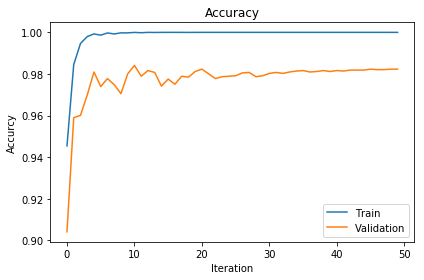

In [16]:
#Plotting the training and validation accuracy curve
acc_plot = plt.subplot(1,1,1)
acc_plot.set_title('Accuracy')
acc_plot.plot(training_acc_history, label ='Train')
acc_plot.plot(validation_acc_history, label ='Validation')
acc_plot.set_xlabel('Iteration')
acc_plot.set_ylabel('Accurcy')
plt.tight_layout()
acc_plot.legend(loc=4)
plt.show()

In [17]:
# checking the test accuracy
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, './train_lenet.ckpt')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./train_lenet.ckpt
Test Set Accuracy = 0.966


In [18]:
#Test the VGGNet model
def VGGNet(x, keep_prob, keep_prob_conv):
    
    mu = 0
    sigma = 0.1

    # Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # ReLu Activation.
    conv1 = tf.nn.relu(conv1)

    # Layer 2 (Convolutional): Input = 32x32x32. Output = 32x32x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b

    # ReLu Activation.
    conv2 = tf.nn.relu(conv2)

    # Layer 3 (Pooling): Input = 32x32x32. Output = 16x16x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob_conv)

    # Layer 4 (Convolutional): Input = 16x16x32. Output = 16x16x64.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b

    # ReLu Activation.
    conv3 = tf.nn.relu(conv3)

    # Layer 5 (Convolutional): Input = 16x16x64. Output = 16x16x64.
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b

    # ReLu Activation.
    conv4 = tf.nn.relu(conv4)

    # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv4 = tf.nn.dropout(conv4, keep_prob_conv) # dropout

    # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
    conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv5_b = tf.Variable(tf.zeros(128))
    conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='SAME') + conv5_b

    # ReLu Activation.
    conv5 = tf.nn.relu(conv5)

    # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
    conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = mu, stddev = sigma))
    conv6_b = tf.Variable(tf.zeros(128))
    conv6   = tf.nn.conv2d(conv5, conv6_W, strides=[1, 1, 1, 1], padding='SAME') + conv6_b

    # ReLu Activation.
    conv6 = tf.nn.relu(conv6)

    # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
    conv6 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv6 = tf.nn.dropout(conv6, keep_prob_conv) # dropout

    # Flatten. Input = 4x4x128. Output = 2048.
    fc0   = flatten(conv6)

    # Layer 10 (Fully Connected): Input = 2048. Output = 128.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(128))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # ReLu Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob) # dropout

    # Layer 11 (Fully Connected): Input = 128. Output = 128.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(128))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # ReLu Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob) # dropout

    # Layer 12 (Fully Connected): Input = 128. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

In [19]:
# employing the learning rate dacay
init_rate = 0.001
EPOCHS = 50
BATCH_SIZE =64
training_acc_history =[]
validation_acc_history =[]

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)
keep_prob_conv = tf.placeholder(tf.float32)
logits = VGGNet(x, keep_prob, keep_prob_conv)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
step = tf.Variable(0, trainable=False)
rate = tf.train.exponential_decay(init_rate, step, 1, 0.9999)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation, global_step=step)

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1, keep_prob_conv: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [21]:
#Adding early stop 
patience = 5
min_delta = 0.001
patience_cnt = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #num_examples = len(X_train)
    num_examples=np.shape(X_train)[0]
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, keep_prob_conv: 0.7})
        
        train_accuracy = evaluate(X_train, y_train)
        training_acc_history.append(train_accuracy)
        
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_acc_history.append(validation_accuracy)
        if i>0 and validation_acc_history[i] - validation_acc_history[i-1]> min_delta:
            patience_cnt = 0
        else:
            patience_cnt += 1
 
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        #if patience_cnt > patience:
            #print("early stopping...")
            #break
        
    saver.save(sess, './train_VGG.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.510

EPOCH 2 ...
Validation Accuracy = 0.774

EPOCH 3 ...
Validation Accuracy = 0.864

EPOCH 4 ...
Validation Accuracy = 0.957

EPOCH 5 ...
Validation Accuracy = 0.978

EPOCH 6 ...
Validation Accuracy = 0.982

EPOCH 7 ...
Validation Accuracy = 0.980

EPOCH 8 ...
Validation Accuracy = 0.988

EPOCH 9 ...
Validation Accuracy = 0.984

EPOCH 10 ...
Validation Accuracy = 0.988

EPOCH 11 ...
Validation Accuracy = 0.988

EPOCH 12 ...
Validation Accuracy = 0.986

EPOCH 13 ...
Validation Accuracy = 0.991

EPOCH 14 ...
Validation Accuracy = 0.988

EPOCH 15 ...
Validation Accuracy = 0.990

EPOCH 16 ...
Validation Accuracy = 0.987

EPOCH 17 ...
Validation Accuracy = 0.990

EPOCH 18 ...
Validation Accuracy = 0.992

EPOCH 19 ...
Validation Accuracy = 0.989

EPOCH 20 ...
Validation Accuracy = 0.991

EPOCH 21 ...
Validation Accuracy = 0.990

EPOCH 22 ...
Validation Accuracy = 0.990

EPOCH 23 ...
Validation Accuracy = 0.989

EPOCH 24 ...
Validation Accura

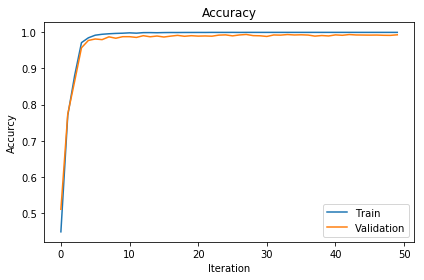

In [22]:
acc_plot = plt.subplot(1,1,1)
acc_plot.set_title('Accuracy')
acc_plot.plot(training_acc_history, label ='Train')
acc_plot.plot(validation_acc_history, label ='Validation')
acc_plot.set_xlabel('Iteration')
acc_plot.set_ylabel('Accurcy')
plt.tight_layout()
acc_plot.legend(loc=4)
plt.show()

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './train_VGG.ckpt')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./train_VGG.ckpt
Test Set Accuracy = 0.978


In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, './train_VGG.ckpt')
    error_count = sess.run(correct_prediction, feed_dict={x: X_test, y: y_test, keep_prob: 1.0, keep_prob_conv: 1.0})

INFO:tensorflow:Restoring parameters from ./train_VGG.ckpt


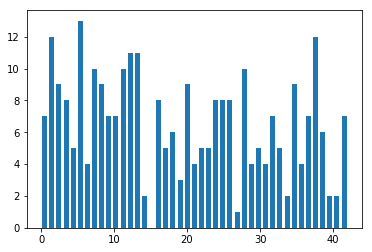

In [25]:
#checking which categories made the most mistake
error_ind=np.where(error_count==False)
error_test=y_train[error_ind]
# redo the augmentation for some categories
hist, bins = np.histogram(error_test, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

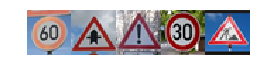

In [26]:
import glob
import matplotlib.image as mpimg

fig, axs = plt.subplots(1,5, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./online_images/*x.png')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image)

img = np.asarray(my_images)
new_images=preprocess_image(img)
new_images=np.array(new_images)

In [27]:
my_labels = [3,11, 18,1, 25]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, './train_VGG.ckpt')
    OUT = sess.run(tf.argmax(logits, 1), feed_dict={x: new_images, y: my_labels, keep_prob: 1.0, keep_prob_conv: 1})
    print("", OUT, "<-predictions")
    print("", my_labels, "<-actual")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, './train_VGG.ckpt')
    test_accuracy = evaluate(new_images, my_labels)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./train_VGG.ckpt
 [ 3 11 18  1 25] <-predictions
 [3, 11, 18, 1, 25] <-actual
INFO:tensorflow:Restoring parameters from ./train_VGG.ckpt
Test Set Accuracy = 1.000


In [28]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, './train_VGG.ckpt')
    OUT_5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: new_images, y: my_labels, keep_prob: 1.0, keep_prob_conv: 1})
    print(OUT_5[1].T)
    print("(top  5 predictions above) for each image")
    
print()    
print("probability for top 5 predictions for each image:")
for i in range(len(my_labels)):
    print(i, OUT_5[0][i].T)

INFO:tensorflow:Restoring parameters from ./train_VGG.ckpt
[[ 3 11 18  1 25]
 [ 5 30 26  0 22]
 [16 28 25  2 29]
 [33 37 27  4 11]
 [15 27 11  5 20]]
(top  5 predictions above) for each image

probability for top 5 predictions for each image:
0 [  1.00000000e+00   7.22670469e-15   4.62976575e-20   4.94732605e-21
   4.30839042e-21]
1 [  1.00000000e+00   5.23105472e-16   1.58270256e-21   3.70903307e-24
   8.41800328e-27]
2 [  1.00000000e+00   7.04281078e-11   3.17348822e-14   1.79705595e-14
   1.47142858e-16]
3 [  1.00000000e+00   9.17219981e-11   6.18408802e-15   2.64603934e-16
   1.22935831e-17]
4 [  1.00000000e+00   1.34532814e-16   4.51197136e-20   3.33177042e-20
   1.70197468e-20]
